In [2]:
# =============================================
# Cell 1 — Imports, config, and paths (cn/en)
# =============================================
import math, random, os, pickle, time, re, json
from pathlib import Path
from collections import defaultdict, Counter

import sentencepiece as spm
import nltk, jieba
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import sacrebleu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download punkt quietly (for English tokenization)
nltk.download('punkt', quiet=True)

# ---- Reproducibility ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---- Project paths ----
# We auto-detect where your split files live. Priority: ./data -> /mnt/data -> .
PREF_CANDIDATES = [Path("data"), Path("/mnt/data"), Path(".")]
for cand in PREF_CANDIDATES:
    if (cand/"train.cn").exists() and (cand/"train.en").exists():
        DATA_DIR = cand
        break
else:
    DATA_DIR = Path("data")  # fallback; user should place files here

ARTIFACTS = Path("artifacts")
TOK_DIR = ARTIFACTS/"tokenizer"
CKPT_DIR = ARTIFACTS/"checkpoints"
TOK_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

SP_MODEL_PATH = TOK_DIR/"bpe_joint.model"   # SentencePiece model file
SP_PREFIX = TOK_DIR/"bpe_joint"
CHECKPOINT_PATH = CKPT_DIR/"nmt_best.pth"
IBM_PICKLE = CKPT_DIR/"ibm1.pkl"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# ---- Hyperparameters ----
VOCAB_SIZE = 16000     # 8000/16000/32000 are common
MAX_LEN = 80
BATCH_SIZE = 16
NUM_EPOCHS = 60
LR = 1e-4
PAD, BOS, EOS, UNK = 0, 1, 2, 3

# SMT params
SMT_MAX = 50000
SMT_BEAM = 6
SMT_NBEST = 5

# ---- Language direction ----
# We standardize: Chinese = "cn" label, English = "en".
# Set direction as needed: "zh2en" (cn->en) or "en2zh" (en->cn)
DIRECTION = "zh2en"

CN_ALIASES = {"cn", "zh", "zh-cn", "zh_cn"}
ENG_ALIASES = {"en", "eng"}

if DIRECTION == "en2zh":
    SRC_LANG, TGT_LANG = "en", "cn"
else:  # default zh2en
    SRC_LANG, TGT_LANG = "cn", "en"

# ---- File paths (use val.* instead of valid.*) ----
TRAIN_SRC = DATA_DIR/f"train.{SRC_LANG}"
TRAIN_TGT = DATA_DIR/f"train.{TGT_LANG}"
VAL_SRC   = DATA_DIR/f"val.{SRC_LANG}"
VAL_TGT   = DATA_DIR/f"val.{TGT_LANG}"
TEST_SRC  = DATA_DIR/f"test.{SRC_LANG}"
TEST_TGT  = DATA_DIR/f"test.{TGT_LANG}"

print("Direction:", DIRECTION, f"  SRC={SRC_LANG}  TGT={TGT_LANG}")
print("DATA_DIR:", DATA_DIR.resolve())
for p in [TRAIN_SRC, TRAIN_TGT, VAL_SRC, VAL_TGT, TEST_SRC, TEST_TGT]:
    print(("✅" if p.exists() else "❌"), p)

# Quick fail if any split is missing
missing = [str(p) for p in [TRAIN_SRC, TRAIN_TGT, VAL_SRC, VAL_TGT, TEST_SRC, TEST_TGT] if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing split files: " + ", ".join(missing) +
        "\nPlease ensure your cleaned splits are present as train.cn/en, val.cn/en, test.cn/en."
    )

c:\Python312\Lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda
Direction: zh2en   SRC=cn  TGT=en
DATA_DIR: D:\AITest\data
✅ data\train.cn
✅ data\train.en
✅ data\val.cn
✅ data\val.en
✅ data\test.cn
✅ data\test.en


In [3]:
# ======================================================
# Cell 2 — Basic cleaners & tokenizers (CN/EN aware)
# ======================================================

def clean_cn(text: str) -> str:
    # Keep CJK, numbers, basic punctuation; strip others
    return re.sub(r"[^\u4e00-\u9fff\u0030-\u0039\s，。！？；：,.?!\"'－—·…]", "", str(text)).strip()

def clean_en(text: str) -> str:
    t = re.sub(r"[^\w\s\.,?!'\"]", "", str(text))
    return re.sub(r"\s+", " ", t).strip()

# Tokenizers

def tok_en(s: str):
    return nltk.word_tokenize(s)

def tok_zh(s: str):
    # jieba for Chinese word segmentation; for character-level LM, you could swap here.
    return list(jieba.cut(s, cut_all=False))


def is_cn(lang: str) -> bool:
    return str(lang).lower() in CN_ALIASES


def is_en(lang: str) -> bool:
    return str(lang).lower() in ENG_ALIASES

In [4]:
# ======================================================
# Cell 3 — Sanity checks on splits (alignment & empties)
# ======================================================

def _count_nonempty_pairs(src_path: Path, tgt_path: Path):
    src = src_path.read_text(encoding="utf-8", errors="ignore").splitlines()
    tgt = tgt_path.read_text(encoding="utf-8", errors="ignore").splitlines()
    if len(src) != len(tgt):
        raise ValueError(f"Line count mismatch: {src_path.name}={len(src)} vs {tgt_path.name}={len(tgt)}")
    n_total = len(src)
    n_empty = sum(1 for a,b in zip(src,tgt) if (not str(a).strip()) or (not str(b).strip()))
    return n_total, n_empty

for (s, t) in [(TRAIN_SRC, TRAIN_TGT), (VAL_SRC, VAL_TGT), (TEST_SRC, TEST_TGT)]:
    total, empty = _count_nonempty_pairs(s, t)
    print(f"{s.name}/{t.name}: total={total:,}  empty_pairs={empty}")

train.cn/train.en: total=14,231  empty_pairs=0
val.cn/val.en: total=1,778  empty_pairs=0
test.cn/test.en: total=1,780  empty_pairs=0


In [5]:
# ======================================================
# Cell 4 — Train or load SentencePiece (joint BPE on train.cn/en)
# ======================================================
if not SP_MODEL_PATH.exists():
    sp_corpus = TOK_DIR/"sp_corpus.txt"
    with open(sp_corpus, "w", encoding="utf-8") as out:
        for p in [TRAIN_SRC, TRAIN_TGT]:
            for ln in open(p, encoding="utf-8", errors="ignore"):
                out.write(str(ln).strip() + "\n")
    print("Training SentencePiece model (joint BPE)…")
    spm.SentencePieceTrainer.Train(
        input=str(sp_corpus),
        model_prefix=str(SP_PREFIX),
        vocab_size=VOCAB_SIZE,
        model_type="bpe",
        character_coverage=0.9995,
        pad_id=PAD, bos_id=BOS, eos_id=EOS, unk_id=UNK
    )
else:
    print("Found existing SP model:", SP_MODEL_PATH)

sp = spm.SentencePieceProcessor(model_file=str(SP_MODEL_PATH))
print("SP vocab size:", sp.get_piece_size())

Found existing SP model: artifacts\tokenizer\bpe_joint.model
SP vocab size: 16000


In [6]:
# ======================================================
# Cell 5 — Dataset & DataLoaders (cn/en files)
# ======================================================

def encode_with_sp(text, max_len=MAX_LEN):
    ids = sp.encode(str(text), out_type=int)
    ids = [BOS] + ids[:max_len-2] + [EOS]
    if len(ids) < max_len:
        ids += [PAD] * (max_len - len(ids))
    return ids

class ParallelDataset(Dataset):
    def __init__(self, src_path: Path, tgt_path: Path, preprocess: bool=False):
        self.src_lines = open(src_path, encoding='utf-8', errors='ignore').read().splitlines()
        self.tgt_lines = open(tgt_path, encoding='utf-8', errors='ignore').read().splitlines()
        assert len(self.src_lines) == len(self.tgt_lines), "Source/Target line count mismatch"
        self.preprocess = preprocess
    def __len__(self):
        return len(self.src_lines)
    def __getitem__(self, idx):
        s = self.src_lines[idx].strip()
        t = self.tgt_lines[idx].strip()
        if self.preprocess:
            s = clean_cn(s) if is_cn(SRC_LANG) else clean_en(s)
            t = clean_en(t) if is_en(TGT_LANG) else clean_cn(t)
        return (
            torch.tensor(encode_with_sp(s), dtype=torch.long),
            torch.tensor(encode_with_sp(t), dtype=torch.long)
        )

train_ds = ParallelDataset(TRAIN_SRC, TRAIN_TGT, preprocess=False)
val_ds   = ParallelDataset(VAL_SRC,   VAL_TGT,   preprocess=False)
test_ds  = ParallelDataset(TEST_SRC,  TEST_TGT,  preprocess=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False)

print("Train batches:", len(train_loader), " Val:", len(val_loader), " Test:", len(test_loader))

# Estimate expected tgt/src length ratio on subwords (for hybrid length penalty)

def compute_avg_tgt_per_src_ratio(src_path: Path, tgt_path: Path, sample=5000):
    src_lines = open(src_path, encoding='utf-8', errors='ignore').read().splitlines()
    tgt_lines = open(tgt_path, encoding='utf-8', errors='ignore').read().splitlines()
    n = min(len(src_lines), len(tgt_lines), sample)
    ratios = []
    for i in range(n):
        s_len = max(1, len(sp.encode(src_lines[i], out_type=int)))
        t_len = max(1, len(sp.encode(tgt_lines[i], out_type=int)))
        ratios.append(t_len / s_len)
    return float(np.mean(ratios)) if ratios else 1.0

AVG_TGT_PER_SRC = compute_avg_tgt_per_src_ratio(TRAIN_SRC, TRAIN_TGT, sample=2000)
print("Approx avg tgt_per_src (subwords):", AVG_TGT_PER_SRC)

Train batches: 889  Val: 112  Test: 1780
Approx avg tgt_per_src (subwords): 1.7171504344876831


In [7]:
# ======================================================
# Cell 6 — SMT training utilities (IBM1 + Bigram LM)
# ======================================================
from nltk.translate import AlignedSent
from nltk.translate.ibm1 import IBMModel1


def _build_aligned_sentences(src_lines, tgt_lines):
    # NLTK IBM1 wants AlignedSent(target_tokens, source_tokens)
    if is_en(SRC_LANG) and is_cn(TGT_LANG):
        # en -> cn
        return [AlignedSent(tok_zh(t), tok_en(s)) for s, t in zip(src_lines, tgt_lines)]
    elif is_cn(SRC_LANG) and is_en(TGT_LANG):
        # cn -> en
        return [AlignedSent(tok_en(t), tok_zh(s)) for s, t in zip(src_lines, tgt_lines)]
    else:
        # default fallback: treat tgt as en, src as cn
        return [AlignedSent(tok_en(t), tok_zh(s)) for s, t in zip(src_lines, tgt_lines)]


def _build_bigram_lm(tgt_lines, tgt_tok):
    counts = defaultdict(Counter)
    unigrams = Counter()
    for line in tgt_lines:
        toks = ["<S>"] + tgt_tok(line) + ["</S>"]
        for i in range(len(toks)-1):
            counts[toks[i]][toks[i+1]] += 1
            unigrams[toks[i]] += 1
    unigrams[toks[-1]] += 1
    return counts, unigrams

# IBM1 sentence logprob under translation table tt (tgt_word -> {src_word: prob})

def ibm1_sentence_logprob(src_tokens, tgt_tokens, tt, null_prob=1e-12):
    l = len(src_tokens)
    denom = float(l + 1)
    total_logp = 0.0
    for tword in tgt_tokens:
        ssum = 0.0
        srcmap = tt.get(tword, {})
        for s in src_tokens:
            ssum += srcmap.get(s, 0.0)
        ssum += srcmap.get("", 0.0)
        if ssum <= 0.0:
            total_logp += math.log(null_prob / denom)
        else:
            total_logp += math.log(ssum / denom)
    return total_logp


def smt_decode_from_tables(src_sentence, translation_table_tt, src2tgt_local, counts_local, unigrams_local, beam_size=SMT_BEAM, n_best=SMT_NBEST):
    src_tokens = tok_zh(src_sentence) if is_cn(SRC_LANG) else tok_en(src_sentence)
    beams = [(0.0, [])]
    vocab_size_lm_local = max(1, len(unigrams_local) if unigrams_local is not None else 1)
    def bigram_logp_local(w1, w2):
        return math.log((counts_local[w1][w2] + 1) / (unigrams_local[w1] + vocab_size_lm_local))
    for s_tok in src_tokens:
        if src2tgt_local is not None:
            cands = src2tgt_local.get(s_tok, [])
        else:
            cands = []
            for tgt_word, src_map in translation_table_tt.items():
                p = src_map.get(s_tok, 0.0)
                if p > 0:
                    cands.append((tgt_word, p))
            cands = sorted(cands, key=lambda x: x[1], reverse=True)[:20]
        if not cands:
            cands = [(s_tok, 1e-6)]
        new_beams = []
        for score_prev, seq in beams:
            prev = seq[-1] if seq else "<S>"
            for tgt_tok, prob in cands:
                sc = score_prev + math.log(max(prob, 1e-12)) + bigram_logp_local(prev, tgt_tok)
                new_beams.append((sc, seq + [tgt_tok]))
        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]
    final = []
    for sc, seq in beams:
        sc_final = sc + bigram_logp_local(seq[-1] if seq else "<S>", "</S>")
        if is_en(TGT_LANG):
            tgt_text = " ".join(seq)
        else:
            tgt_text = "".join(seq)
        final.append((sc_final, tgt_text))
    final.sort(key=lambda x: x[0], reverse=True)
    return final[:n_best]

# Initialize or load SMT artifacts
if os.path.exists(IBM_PICKLE):
    print("SMT artifact exists, will load in next cell:", IBM_PICKLE)
else:
    print("No SMT artifact found: doing a quick single-shot train (5 iters) to initialize.")
    src_lines = open(TRAIN_SRC, encoding='utf-8', errors='ignore').read().splitlines()[:SMT_MAX]
    tgt_lines = open(TRAIN_TGT, encoding='utf-8', errors='ignore').read().splitlines()[:SMT_MAX]
    aligned = _build_aligned_sentences(src_lines, tgt_lines)
    ibm1 = IBMModel1(aligned, 5)
    tgt_tok = tok_zh if is_cn(TGT_LANG) else tok_en
    counts, unigrams = _build_bigram_lm(tgt_lines, tgt_tok)
    translation_table_serializable = {}
    for tgt_word, src_map in ibm1.translation_table.items():
        translation_table_serializable[tgt_word] = {src_word: float(prob) for src_word, prob in src_map.items()}
    src2tgt = defaultdict(list)
    for tgt_word, src_map in translation_table_serializable.items():
        for s_word, p in src_map.items():
            src2tgt[s_word].append((tgt_word, p))
    for s in src2tgt:
        src2tgt[s].sort(key=lambda x: x[1], reverse=True)
        src2tgt[s] = src2tgt[s][:50]
    with open(IBM_PICKLE, "wb") as f:
        pickle.dump({
            "translation_table": translation_table_serializable,
            "bigram_counts": counts,
            "unigrams": unigrams,
            "src2tgt": src2tgt
        }, f)
    print("Saved initial SMT artifact to", IBM_PICKLE)


def train_smt_with_eval(num_iters=30, eval_src=VAL_SRC, eval_tgt=VAL_TGT, sample_train_for_loss=None, save_history_csv=CKPT_DIR/"smt_train_history.csv", verbose=True):
    os.makedirs(CKPT_DIR, exist_ok=True)
    print(f"train_smt_with_eval: num_iters={num_iters}  sample_train_for_loss={sample_train_for_loss}")
    src_lines = open(TRAIN_SRC, encoding='utf-8', errors='ignore').read().splitlines()[:SMT_MAX]
    tgt_lines = open(TRAIN_TGT, encoding='utf-8', errors='ignore').read().splitlines()[:SMT_MAX]
    aligned = _build_aligned_sentences(src_lines, tgt_lines)

    tgt_tok = tok_zh if is_cn(TGT_LANG) else tok_en
    counts_lm, unigrams_lm = _build_bigram_lm(tgt_lines, tgt_tok)

    eval_src_lines = open(eval_src, encoding='utf-8', errors='ignore').read().splitlines()
    eval_tgt_lines = open(eval_tgt, encoding='utf-8', errors='ignore').read().splitlines()

    if sample_train_for_loss is None:
        train_for_loss_src = src_lines
        train_for_loss_tgt = tgt_lines
    else:
        idxs = list(range(len(src_lines)))
        random.shuffle(idxs)
        sel = idxs[:min(sample_train_for_loss, len(idxs))]
        train_for_loss_src = [src_lines[i] for i in sel]
        train_for_loss_tgt = [tgt_lines[i] for i in sel]

    history = []
    best_bleu = -1.0

    for iters in range(1, num_iters+1):
        if verbose: print(f"\n=== IBMModel1 training with {iters} iterations ===")
        ibm = IBMModel1(aligned, iters)  # retrain from scratch with i iterations

        tt = {tgt_word: {src_w: float(p) for src_w, p in src_map.items()} for tgt_word, src_map in ibm.translation_table.items()}
        s2t = defaultdict(list)
        for tgt_word, src_map in tt.items():
            for s_word, p in src_map.items():
                s2t[s_word].append((tgt_word, p))
        for s in s2t:
            s2t[s].sort(key=lambda x: x[1], reverse=True)
            s2t[s] = s2t[s][:50]

        # decode validation set with this tt and compute top1 BLEU
        hyps = []
        for src in tqdm(eval_src_lines, desc=f"decoding iter={iters}"):
            nbest = smt_decode_from_tables(src, tt, s2t, counts_lm, unigrams_lm, beam_size=SMT_BEAM, n_best=1)
            hyps.append(nbest[0][1] if nbest else "")

        try:
            bleu = sacrebleu.corpus_bleu(hyps, [eval_tgt_lines], force=True).score
        except TypeError:
            bleu = sacrebleu.corpus_bleu(hyps, [eval_tgt_lines]).score

        # compute training negative avg log-likelihood (NLL) on sampled train subset
        train_ll_sum = 0.0
        for s_src, s_tgt in zip(train_for_loss_src, train_for_loss_tgt):
            src_toks = tok_zh(s_src) if is_cn(SRC_LANG) else tok_en(s_src)
            tgt_toks = tok_en(s_tgt) if is_en(TGT_LANG) else tok_zh(s_tgt)
            train_ll_sum += ibm1_sentence_logprob(src_toks, tgt_toks, tt)
        avg_train_ll = train_ll_sum / max(1, len(train_for_loss_src))
        train_nll = - avg_train_ll

        if verbose: print(f"Iter {iters} => SMT_top1 BLEU: {bleu:.2f}  |  avg train NLL = {train_nll:.4f}")

        entry = {"iter": iters, "smt_bleu": float(bleu), "train_nll": float(train_nll)}
        history.append(entry)

        iter_ckpt_path = CKPT_DIR/f"ibm1_iter{iters}.pkl"
        with open(iter_ckpt_path, "wb") as f:
            pickle.dump({
                "translation_table": tt,
                "bigram_counts": counts_lm,
                "unigrams": unigrams_lm,
                "src2tgt": s2t,
                "iter": iters,
                "smt_bleu": float(bleu)
            }, f)
        if verbose: print("Saved iter checkpoint:", iter_ckpt_path)

        if bleu > best_bleu:
            best_bleu = float(bleu)
            with open(IBM_PICKLE, "wb") as f:
                pickle.dump({
                    "translation_table": tt,
                    "bigram_counts": counts_lm,
                    "unigrams": unigrams_lm,
                    "src2tgt": s2t,
                    "best_iter": iters,
                    "best_bleu": best_bleu
                }, f)
            if verbose: print("New BEST SMT model saved to", IBM_PICKLE, " (iter:", iters, "bleu:", best_bleu, ")")

        # write history CSV incrementally
        pd.DataFrame(history).to_csv(str(save_history_csv), index=False, encoding='utf-8')
        if verbose: print("Saved SMT history to", save_history_csv)

    return pd.DataFrame(history)

# df = train_smt_with_eval(num_iters=30, sample_train_for_loss=2000)

SMT artifact exists, will load in next cell: artifacts\checkpoints\ibm1.pkl


In [8]:
# ======================================================
# Cell 7 — Load SMT artifact & decoding helpers
# ======================================================
if not os.path.exists(IBM_PICKLE):
    raise FileNotFoundError(f"{IBM_PICKLE} not found. Run Cell 6 train_smt_with_eval first.")

with open(IBM_PICKLE, "rb") as f:
    ibm_saved = pickle.load(f)

translation_table = ibm_saved.get("translation_table", {})
counts_raw = ibm_saved.get("bigram_counts", {})
unigrams_raw = ibm_saved.get("unigrams", {})
src2tgt_saved = ibm_saved.get("src2tgt", None)

counts = defaultdict(Counter)
if isinstance(counts_raw, dict):
    for w1, inner in counts_raw.items():
        counts[w1].update(inner)
else:
    try:
        for w1, inner in counts_raw:
            counts[w1].update(inner)
    except Exception:
        pass

if isinstance(unigrams_raw, Counter):
    unigrams = unigrams_raw
else:
    try:
        unigrams = Counter(unigrams_raw)
    except Exception:
        unigrams = Counter()
        for w1 in counts:
            unigrams[w1] = sum(counts[w1].values())

if src2tgt_saved is not None:
    src2tgt = {}
    for s, lst in src2tgt_saved.items():
        if isinstance(lst, dict):
            items = sorted([(k, float(v)) for k,v in lst.items()], key=lambda x: x[1], reverse=True)
        else:
            items = [(k, float(v)) for k,v in lst]
            items = sorted(items, key=lambda x: x[1], reverse=True)
        src2tgt[s] = items[:50]
else:
    src2tgt = defaultdict(list)
    for tgt_word, src_map in translation_table.items():
        for s_word, p in src_map.items():
            src2tgt[s_word].append((tgt_word, float(p)))
    for s in list(src2tgt.keys()):
        src2tgt[s].sort(key=lambda x: x[1], reverse=True)
        src2tgt[s] = src2tgt[s][:50]

vocab_size_lm = max(1, len(unigrams))
print(f"Loaded SMT artifact from {IBM_PICKLE}")
print("  translation_table entries (tgt tokens):", len(translation_table))
print("  bigram counts entries (w1 keys):", len(counts))
print("  unigrams size (vocab_size_lm):", vocab_size_lm)
print("  src2tgt mapping size (source types):", len(src2tgt))
print("  best_iter:", ibm_saved.get("best_iter"), " best_bleu:", ibm_saved.get("best_bleu"))


def bigram_logp_loaded(w1, w2):
    c_w1 = unigrams.get(w1, 0)
    denom = (c_w1 + vocab_size_lm)
    num = counts[w1].get(w2, 0) + 1
    return math.log(num / denom)


def smt_decode_loaded(src_sentence, beam_size=SMT_BEAM, n_best=SMT_NBEST):
    src_tokens = tok_zh(src_sentence) if is_cn(SRC_LANG) else tok_en(src_sentence)
    beams = [(0.0, [])]
    for s_tok in src_tokens:
        cands = src2tgt.get(s_tok, [])
        if not cands:
            cands = [(s_tok, 1e-6)]
        cands = cands[:20]
        new_beams = []
        for prev_score, seq in beams:
            prev_tok = seq[-1] if seq else "<S>"
            for tgt_tok, prob in cands:
                sc = prev_score + math.log(max(prob, 1e-12)) + bigram_logp_loaded(prev_tok, tgt_tok)
                new_beams.append((sc, seq + [tgt_tok]))
        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]
    final = []
    for sc, seq in beams:
        sc_final = sc + bigram_logp_loaded(seq[-1] if seq else "<S>", "</S>")
        text = " ".join(seq) if is_en(TGT_LANG) else "".join(seq)
        final.append((sc_final, text))
    final.sort(key=lambda x: x[0], reverse=True)
    return final[:n_best]


def pretty_format_smt(nbest):
    return "\n".join([f"{score:.3f}\t{text}" for score, text in nbest])

Loaded SMT artifact from artifacts\checkpoints\ibm1.pkl
  translation_table entries (tgt tokens): 5170
  bigram counts entries (w1 keys): 5741
  unigrams size (vocab_size_lm): 5172
  src2tgt mapping size (source types): 8582
  best_iter: 9  best_bleu: 6.934074472214219


In [9]:
# ======================================================
# Cell 8 — TinyTransformer (NMT) & optimizer
# ======================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:,:x.size(1),:].to(x.device)

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=3, dim_feedforward=512, max_len=MAX_LEN):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.src_emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.tgt_emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos = PositionalEncoding(d_model, max_len=max_len)
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.1, batch_first=True)
        dec_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout=0.1, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_layers)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, src_ids, tgt_ids):
        tgt_in = tgt_ids[:, :-1]
        src_mask = (src_ids == PAD)
        tgt_key_padding_mask = (tgt_in == PAD)
        src_emb = self.pos(self.src_emb(src_ids) * math.sqrt(self.d_model))
        memory = self.encoder(src_emb, src_key_padding_mask=src_mask)
        tgt_emb = self.pos(self.tgt_emb(tgt_in) * math.sqrt(self.d_model))
        sz = tgt_emb.size(1)
        tgt_mask = torch.triu(torch.ones(sz, sz, device=src_ids.device), diagonal=1).bool()
        out = self.decoder(tgt_emb, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=src_mask)
        logits = self.out(out)
        return logits

    @torch.no_grad()
    def greedy_decode(self, src_ids, max_len=None, no_repeat_ngram_size=3):
        if max_len is None: max_len = MAX_LEN
        self.eval()
        src_mask = (src_ids == PAD)
        src_emb = self.pos(self.src_emb(src_ids) * math.sqrt(self.d_model))
        memory = self.encoder(src_emb, src_key_padding_mask=src_mask)
        ys = torch.full((src_ids.size(0), 1), BOS, dtype=torch.long, device=src_ids.device)
        assert src_ids.size(0) == ys.size(0)
        for _ in range(max_len-1):
            tgt_emb = self.pos(self.tgt_emb(ys) * math.sqrt(self.d_model))
            L = tgt_emb.size(1)
            tgt_mask = torch.triu(torch.ones(L, L, device=src_ids.device), diagonal=1).bool()
            dec = self.decoder(tgt_emb, memory, tgt_mask=tgt_mask, memory_key_padding_mask=src_mask)
            logits = self.out(dec)[:, -1, :]  # (B, V)
            # no-repeat-ngram masking (batch size 1 recommended)
            if no_repeat_ngram_size and no_repeat_ngram_size > 0 and ys.size(1) >= no_repeat_ngram_size:
                seq = ys[0].tolist()
                n = no_repeat_ngram_size
                seen = set()
                for i in range(len(seq) - n + 1):
                    seen.add(tuple(seq[i:i+n]))
                prefix = tuple(seq[-(n-1):]) if n-1 > 0 else tuple()
                forbidden = set()
                for ng in seen:
                    if ng[:-1] == prefix:
                        forbidden.add(ng[-1])
                if forbidden:
                    logits[0, list(forbidden)] = -1e9
            next_tok = logits.argmax(-1, keepdim=True)
            ys = torch.cat([ys, next_tok], dim=1)
            if (next_tok == EOS).all():
                break
        return ys

vocab_size = sp.get_piece_size()
nmt_model = TinyTransformer(vocab_size=vocab_size).to(DEVICE)
optimizer = torch.optim.Adam(nmt_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=PAD)

In [10]:
# ======================================================
# Cell 9 — NMT train/validate helpers
# ======================================================

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for src, tgt in tqdm(loader, desc="train"):
        src = src.to(DEVICE); tgt = tgt.to(DEVICE)
        optimizer.zero_grad()
        logits = model(src, tgt)
        gold = tgt[:,1:]
        loss = criterion(logits.reshape(-1, logits.size(-1)), gold.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(1, len(loader))


def decode_greedy_text_with_constraints(model, sp, text, no_repeat_ngram_size=3):
    ids = encode_with_sp(text)
    src = torch.tensor([ids], dtype=torch.long, device=DEVICE)
    out_ids = model.greedy_decode(src, max_len=MAX_LEN, no_repeat_ngram_size=no_repeat_ngram_size)[0].tolist()
    seq = [i for i in out_ids if i not in (PAD, BOS, EOS)]
    return sp.decode(seq)


def validate_bleu(model, loader):
    hyps, refs = [], []
    with torch.no_grad():
        for src, tgt in tqdm(loader, desc="valid"):
            src_text = sp.decode([i for i in src[0].tolist() if i not in (PAD, BOS, EOS)])
            hyp = decode_greedy_text_with_constraints(model, sp, src_text, no_repeat_ngram_size=3)
            ref = sp.decode([i for i in tgt[0].tolist() if i not in (PAD, BOS, EOS)])
            hyps.append(hyp); refs.append(ref)
    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    return bleu

In [18]:
# ======================================================
# Cell 10 — NMT training loop (+ history CSV)
# ======================================================

best_bleu = 0.0
os.makedirs(CKPT_DIR, exist_ok=True)

start_epoch = 1
history = {"epoch": [], "train_loss": [], "val_bleu": []}
hist_csv = CKPT_DIR/"nmt_train_history.csv"

if os.path.exists(CHECKPOINT_PATH):
    try:
        ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        if 'model_state' in ckpt:
            nmt_model.load_state_dict(ckpt['model_state'])
        else:
            nmt_model.load_state_dict(ckpt)
        if 'optim_state' in ckpt:
            optimizer.load_state_dict(ckpt['optim_state'])
        start_epoch = ckpt.get('epoch', 0) + 1
        best_bleu = ckpt.get('val_bleu', 0.0)
        print(f"Resuming from checkpoint: start_epoch={start_epoch}, best_bleu={best_bleu}")
    except Exception as e:
        print("Failed to resume checkpoint:", e)
        print("Training from scratch.")
else:
    print("No NMT checkpoint found; training from scratch.")

# Run training loop (optionally adjust NUM_EPOCHS in Cell 1)
for epoch in range(start_epoch, NUM_EPOCHS+1):
    t0 = time.time()
    train_loss = train_one_epoch(nmt_model, train_loader, optimizer, criterion)
    val_bleu = validate_bleu(nmt_model, val_loader)
    elapsed = time.time() - t0
    print(f"Epoch {epoch} train_loss={train_loss:.4f} val_bleu={val_bleu:.2f} time={elapsed:.1f}s")

    ckpt = {'epoch': epoch, 'model_state': nmt_model.state_dict(), 'optim_state': optimizer.state_dict(), 'val_bleu': val_bleu}
    torch.save(ckpt, CKPT_DIR/f"nmt_epoch{epoch}.pth")

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_bleu"].append(val_bleu)
    pd.DataFrame(history).to_csv(hist_csv, index=False, encoding='utf-8')

    if val_bleu > best_bleu:
        best_bleu = val_bleu
        torch.save(ckpt, CHECKPOINT_PATH)
        print("Saved NEW BEST checkpoint:", CHECKPOINT_PATH)

print("Training done; best val BLEU:", best_bleu)
print("Saved NMT history to:", hist_csv)


Resuming from checkpoint: start_epoch=44, best_bleu=15.251333769374066


train:   1%|          | 6/889 [00:04<11:53,  1.24it/s]


KeyboardInterrupt: 

In [11]:
# ======================================================
# Cell 11 — NMT inference & logprob (teacher-forced)
# ======================================================
@torch.no_grad()
def nmt_greedy(src_text: str):
    return decode_greedy_text_with_constraints(nmt_model, sp, src_text, no_repeat_ngram_size=3)

@torch.no_grad()
def nmt_logprob(src_text: str, tgt_text: str):
    """Return total logprob and per-token avg logprob for tgt_text under model."""
    nmt_model.eval()
    src_ids = torch.tensor([encode_with_sp(src_text)], dtype=torch.long, device=DEVICE)
    tgt_ids = torch.tensor([encode_with_sp(tgt_text)], dtype=torch.long, device=DEVICE)
    logits = nmt_model(src_ids, tgt_ids)  # (1, T-1, V)
    logp = F.log_softmax(logits, dim=-1)
    total = 0.0
    for t in range(logp.size(1)):
        token = int(tgt_ids[0, t+1].item())
        total += float(logp[0, t, token].item())
    tgt_tokens = sp.encode(tgt_text, out_type=int)
    avg = total / max(1, len(tgt_tokens))
    return total, avg, len(tgt_tokens)

In [12]:
# ======================================================
# Cell 12 — Hybrid reranker (SMT + NMT + length agreement)
# ======================================================

def compute_smt_score_for_candidate(src_sentence, cand_text, translation_table_local, counts_local, unigrams_local):
    src_toks = tok_zh(src_sentence) if is_cn(SRC_LANG) else tok_en(src_sentence)
    tgt_toks = tok_en(cand_text) if is_en(TGT_LANG) else tok_zh(cand_text)

    l = max(1, len(src_toks))
    denom = float(l + 1)
    total_logp = 0.0
    for tj in tgt_toks:
        srcmap = translation_table_local.get(tj, {}) if translation_table_local is not None else {}
        ssum = 0.0
        for si in src_toks:
            ssum += srcmap.get(si, 0.0)
        ssum += srcmap.get("", 0.0)
        total_logp += math.log((ssum/denom) if ssum > 0 else (1e-12/denom))

    vocab_lm = max(1, len(unigrams_local) if unigrams_local is not None else 1)
    lm_logp = 0.0
    prev = "<S>"
    for tok in tgt_toks:
        num = counts_local[prev].get(tok, 0) + 1
        denom2 = unigrams_local.get(prev, 0) + vocab_lm
        if denom2 <= 0:
            denom2 = vocab_lm
        lm_logp += math.log(num / denom2)
        prev = tok
    num = counts_local[prev].get("</S>", 0) + 1
    denom2 = unigrams_local.get(prev, 0) + vocab_lm
    if denom2 <= 0:
        denom2 = vocab_lm
    lm_logp += math.log(num / denom2)

    return float(total_logp + lm_logp)


def _normalize_series(arr):
    a = np.array(arr, dtype=float)
    if np.isnan(a).all():
        return np.full_like(a, 0.5, dtype=float)
    nan_mask = np.isnan(a)
    if nan_mask.any():
        nm = np.nanmin(a)
        a[nan_mask] = nm - 1e-6
    mn, mx = float(np.min(a)), float(np.max(a))
    if abs(mx - mn) < 1e-12:
        return np.full_like(a, 0.5, dtype=float)
    return (a - mn) / (mx - mn)


def hybrid_rerank_and_table(src_sentence, alpha=0.6, beam_size=SMT_BEAM, n_best=SMT_NBEST, len_weight=0.15, debug=False):
    nbest = smt_decode_loaded(src_sentence, beam_size=beam_size, n_best=n_best)
    cand_texts = [t for _, t in nbest] if nbest else []
    try:
        nmt_g = nmt_greedy(src_sentence)
    except Exception:
        nmt_g = ""
    if nmt_g and nmt_g not in cand_texts:
        cand_texts.append(nmt_g)

    if not cand_texts:
        return "", pd.DataFrame([])

    rows = []
    src_tokens_len = len(tok_zh(src_sentence)) if is_cn(SRC_LANG) else len(tok_en(src_sentence))
    expected_len = max(1, int(round(src_tokens_len * (AVG_TGT_PER_SRC if 'AVG_TGT_PER_SRC' in globals() else 1.0))))

    for cand in list(map(str, cand_texts)):
        try:
            smt_sc = compute_smt_score_for_candidate(src_sentence, cand, translation_table, counts, unigrams)
        except Exception:
            smt_sc = float('-1e12')
        try:
            nmt_total, nmt_avg, nmt_tok = nmt_logprob(src_sentence, cand)
        except Exception:
            nmt_total, nmt_avg, nmt_tok = float('-1e12'), float('-1e12'), 0
        len_diff = abs(int(nmt_tok) - expected_len)
        len_penalty = - (len_diff / max(1, expected_len))
        rows.append({
            "candidate": cand,
            "smt_score": float(smt_sc),
            "nmt_total_lp": float(nmt_total),
            "nmt_avg_lp": float(nmt_avg),
            "nmt_tokens": int(nmt_tok),
            "len_penalty": float(len_penalty),
            "source": "SMT_nbest" if cand in [t for _, t in nbest] else "NMT_greedy"
        })

    df = pd.DataFrame(rows)
    for col in ['smt_score', 'nmt_avg_lp', 'len_penalty']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].isna().all():
                df[col] = df[col].fillna(0.0)
            else:
                mn = float(np.nanmin(df[col].values))
                df[col] = df[col].fillna(mn - 1e-6)

    df['smt_norm'] = _normalize_series(df['smt_score'].values)
    df['nmt_norm'] = _normalize_series(df['nmt_avg_lp'].values)
    df['len_norm'] = _normalize_series(df['len_penalty'].values)
    df['blended'] = (1.0 - len_weight) * (alpha * df['nmt_norm'] + (1.0 - alpha) * df['smt_norm']) + len_weight * df['len_norm']

    df = df.sort_values(by='blended', ascending=False).reset_index(drop=True)
    if debug:
        print("DEBUG hybrid rerank: candidates =", len(df))
        print("smt_score min/max:", float(df['smt_score'].min()), "/", float(df['smt_score'].max()))
        print("nmt_avg_lp  min/max:", float(df['nmt_avg_lp'].min()), "/", float(df['nmt_avg_lp'].max()))
        print("len_penalty min/max:", float(df['len_penalty'].min()), "/", float(df['len_penalty'].max()))
        display(df.head(3)); display(df.tail(3))

    best = df.loc[0, 'candidate']
    return best, df


def translate_and_record(src_sentence, alpha=0.6, print_table=True, debug=False):
    best, df = hybrid_rerank_and_table(src_sentence, alpha=alpha, debug=debug)
    smt_nbest = smt_decode_loaded(src_sentence)
    try:
        nmt_g = nmt_greedy(src_sentence)
    except Exception:
        nmt_g = ""
    print("="*70)
    print("SRC:", src_sentence)
    print("\nSMT n-best:")
    if smt_nbest:
        for s, t in smt_nbest:
            print(f"  {s:.3f}\t{t}")
    else:
        print("  (no SMT candidates)")
    print("\nNMT greedy:", nmt_g)
    print("\nHybrid rerank table (top rows):")
    if print_table and (not df.empty):
        display(df.head(10))
    print("FINAL CHOSEN (blended top):", best)
    return best, df

In [13]:
# ======================================================
# Cell 13 — Batch evaluation on TEST (Hybrid only)
# ======================================================

def evaluate_hybrid_on_test(alpha=0.6, save_csv_path=None):
    src_lines = open(TEST_SRC, encoding='utf-8', errors='ignore').read().splitlines()
    ref_lines = open(TEST_TGT, encoding='utf-8', errors='ignore').read().splitlines()
    assert len(src_lines) == len(ref_lines)
    hybrid_hyps = []
    per_sent_records = []
    for src, ref in tqdm(zip(src_lines, ref_lines), total=len(src_lines), desc="evaluating hybrid"):
        hybrid_best, df = hybrid_rerank_and_table(src, alpha=alpha)
        hybrid_hyps.append(hybrid_best)
        top_row = df.iloc[0].to_dict() if not df.empty else {}
        rec = {
            "src": src, "ref": ref,
            "hybrid_best": hybrid_best,
            "hybrid_smt_score": top_row.get('smt_score', None),
            "hybrid_nmt_avg_lp": top_row.get('nmt_avg_lp', None),
            "hybrid_len_penalty": top_row.get('len_penalty', None),
            "hybrid_blended": top_row.get('blended', None)
        }
        per_sent_records.append(rec)
    hybrid_bleu = sacrebleu.corpus_bleu(hybrid_hyps, [ref_lines]).score
    print("HYBRID BLEU on test:", hybrid_bleu)
    df_records = pd.DataFrame(per_sent_records)
    if save_csv_path:
        df_records.to_csv(save_csv_path, index=False, encoding='utf-8')
        print("Saved per-sentence hybrid results to", save_csv_path)
    return {"hybrid_bleu": hybrid_bleu}, df_records

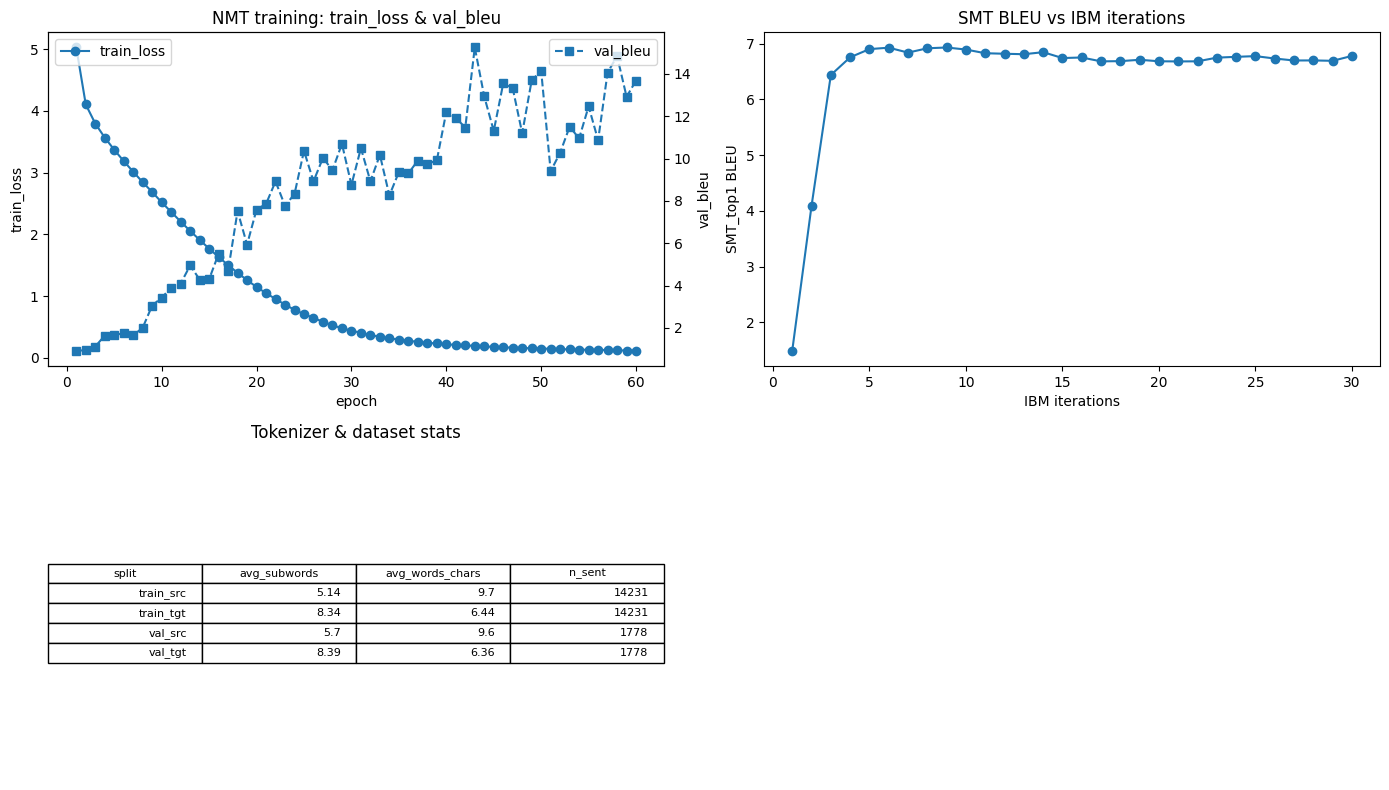

,epoch,train_loss,val_bleu
0,1,5.024886,0.920539
1,2,4.102135,0.940104
2,3,3.793688,1.115612
3,4,3.566101,1.636268
4,5,3.368747,1.645438
5,6,3.185104,1.757042
6,7,3.012697,1.643023
7,8,2.843468,2.007809
8,9,2.684261,3.055917
9,10,2.518107,3.424917


,iter,smt_bleu,train_nll
0,1,1.488015,28.729398
1,2,4.088708,24.781930
2,3,6.439743,23.542447
3,4,6.758093,23.111930
4,5,6.905209,22.927818
5,6,6.930678,22.835918
6,7,6.842264,22.785338
7,8,6.920080,22.755819
8,9,6.934074,22.737990
9,10,6.897123,22.726987


In [14]:
# ======================================================
# Cell 14 — Plots: NMT & SMT histories + dataset stats
# ======================================================

nmt_hist_path = CKPT_DIR/"nmt_train_history.csv"
ndf = pd.read_csv(nmt_hist_path) if nmt_hist_path.exists() else None

smt_hist_path = CKPT_DIR/"smt_train_history.csv"
sdf = pd.read_csv(smt_hist_path) if smt_hist_path.exists() else None


def avg_token_stats(file_path: Path, side_lang: str):
    if not file_path.exists():
        return {"avg_subwords": None, "avg_words_chars": None, "n_sent": 0}
    lines = open(file_path, encoding='utf-8', errors='ignore').read().splitlines()
    lens = [len(sp.encode(l, out_type=int)) for l in lines]
    if is_cn(side_lang):
        charlens = [len(re.sub(r"\s+", "", l)) for l in lines]  # char count for CN
    else:
        charlens = [len(l.split()) for l in lines]  # word count for EN
    return {"avg_subwords": float(np.mean(lens)), "avg_words_chars": float(np.mean(charlens)), "n_sent": len(lines)}

train_src_stats = avg_token_stats(TRAIN_SRC, SRC_LANG)
train_tgt_stats = avg_token_stats(TRAIN_TGT, TGT_LANG)
val_src_stats   = avg_token_stats(VAL_SRC,   SRC_LANG)
val_tgt_stats   = avg_token_stats(VAL_TGT,   TGT_LANG)

fig, axs = plt.subplots(2,2, figsize=(14,8))
axs = axs.flatten()

# A: NMT train_loss & val_bleu
ax = axs[0]
if ndf is not None and not ndf.empty:
    ax2 = ax.twinx()
    ax.plot(ndf['epoch'], ndf['train_loss'], marker='o', label='train_loss')
    ax2.plot(ndf['epoch'], ndf['val_bleu'], marker='s', label='val_bleu', linestyle='--')
    ax.set_xlabel('epoch'); ax.set_ylabel('train_loss')
    ax2.set_ylabel('val_bleu')
    ax.set_title('NMT training: train_loss & val_bleu')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
else:
    ax.text(0.1,0.5,"No NMT history CSV found.\nRun Cell 10 to train and record history.", fontsize=10)
    ax.axis('off')

# B: SMT BLEU vs IBM iterations
ax = axs[1]
if sdf is not None and not sdf.empty:
    ax.plot(sdf['iter'], sdf['smt_bleu'], marker='o')
    ax.set_xlabel('IBM iterations'); ax.set_ylabel('SMT_top1 BLEU')
    ax.set_title('SMT BLEU vs IBM iterations')
else:
    ax.text(0.1,0.5,"No SMT history CSV found.\nRun train_smt_with_eval(num_iters=...) in Cell 6.", fontsize=10)
    ax.axis('off')

# C: Tokenizer & dataset stats table
ax = axs[2]
ax.axis('off')
tbl = pd.DataFrame({
    'split': ['train_src','train_tgt','val_src','val_tgt'],
    'avg_subwords':[train_src_stats['avg_subwords'], train_tgt_stats['avg_subwords'], val_src_stats['avg_subwords'], val_tgt_stats['avg_subwords']],
    'avg_words_chars':[train_src_stats.get('avg_words_chars'), train_tgt_stats.get('avg_words_chars'), val_src_stats.get('avg_words_chars'), val_tgt_stats.get('avg_words_chars')],
    'n_sent':[train_src_stats['n_sent'], train_tgt_stats['n_sent'], val_src_stats['n_sent'], val_tgt_stats['n_sent']]
})
ax.table(cellText=tbl.round(2).fillna("N/A").values, colLabels=tbl.columns, loc='center')
ax.set_title('Tokenizer & dataset stats')

# D: Guidance box
ax = axs[3]
# ax.text(0.05,0.5,"Run evaluate_hybrid_on_test() (Cell 13) to compute Hybrid BLEU on test and save per-sentence CSV", fontsize=9)
ax.axis('off')

plt.tight_layout()
plt.show()

if ndf is not None:
    display(ndf)
if sdf is not None:
    display(sdf)


In [20]:
# ======================================================
# Load best NMT checkpoint (nmt_best.pth)
# ======================================================
if os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    if 'model_state' in ckpt:
        nmt_model.load_state_dict(ckpt['model_state'])
    else:
        nmt_model.load_state_dict(ckpt)  # fallback
    print(f"Loaded best NMT checkpoint from {CHECKPOINT_PATH} with val_bleu={ckpt.get('val_bleu', 'N/A')}")
    nmt_model.eval()
else:
    raise FileNotFoundError(f"No best NMT checkpoint found at {CHECKPOINT_PATH}. Please run training first.")


Loaded best NMT checkpoint from artifacts\checkpoints\nmt_best.pth with val_bleu=15.251333769374066


Running hybrid-only evaluation on TEST set… (this can take some time)


evaluating hybrid:   7%|▋         | 124/1780 [02:13<29:38,  1.07s/it]


KeyboardInterrupt: 

In [21]:

# ======================================================
# Cell 15 — Hybrid-only evaluation summary (BLEU + chrF + token metrics + exact match)
# ======================================================
from collections import Counter as _Counter
import sacrebleu


def _tokenize_for_metrics(text, lang):
    if not text or str(text).strip()=="":
        return []
    if is_en(lang):
        return nltk.word_tokenize(text)
    else:
        return list(str(text).replace(" ", ""))


def corpus_token_metrics(hyps, refs, lang):
    assert len(hyps) == len(refs)
    total_pred_tokens = 0
    total_ref_tokens = 0
    total_matching = 0
    exact_matches = 0
    for h, r in zip(hyps, refs):
        h_tokens = _tokenize_for_metrics(h, lang)
        r_tokens = _tokenize_for_metrics(r, lang)
        total_pred_tokens += len(h_tokens)
        total_ref_tokens += len(r_tokens)
        ch = _Counter(h_tokens)
        cr = _Counter(r_tokens)
        inter = sum(min(ch[w], cr[w]) for w in (set(ch.keys()) | set(cr.keys())))
        total_matching += inter
        if str(h).strip() == str(r).strip():
            exact_matches += 1
    precision = (total_matching / total_pred_tokens) if total_pred_tokens > 0 else 0.0
    recall = (total_matching / total_ref_tokens) if total_ref_tokens > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    exact_acc = exact_matches / len(hyps) if len(hyps)>0 else 0.0
    return {"precision": precision, "recall": recall, "f1": f1, "exact_acc": exact_acc}


print("Running hybrid-only evaluation on TEST set… (this can take some time)")
results, rec_df = evaluate_hybrid_on_test(alpha=0.6, save_csv_path=str(CKPT_DIR/"hybrid_test_results.csv"))
hybrid_bleu = results['hybrid_bleu']
refs = rec_df['ref'].tolist()
hyps = rec_df['hybrid_best'].tolist()

# chrF calculation
chrf = sacrebleu.corpus_chrf(hyps, [refs]).score

hybrid_metrics = corpus_token_metrics(hyps, refs, TGT_LANG)
summary = pd.DataFrame([{ "system": "HYBRID", "bleu": hybrid_bleu, "chrf": chrf, **hybrid_metrics }]).round(4)
display(summary)
summary.to_csv(CKPT_DIR/"hybrid_summary_metrics.csv", index=False, encoding='utf-8')
print("Saved hybrid summary to:", CKPT_DIR/"hybrid_summary_metrics.csv")


Running hybrid-only evaluation on TEST set… (this can take some time)


evaluating hybrid:   0%|          | 0/1780 [00:00<?, ?it/s]

evaluating hybrid: 100%|██████████| 1780/1780 [06:55<00:00,  4.29it/s]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


HYBRID BLEU on test: 10.398938537914157
Saved per-sentence hybrid results to artifacts\checkpoints\hybrid_test_results.csv


,system,bleu,chrf,precision,recall,f1,exact_acc
0,HYBRID,10.3989,27.3325,0.4919,0.4673,0.4793,0.0124


Saved hybrid summary to: artifacts\checkpoints\hybrid_summary_metrics.csv


In [ ]:
translate_and_record("")

SRC: 旅行

SMT n-best:
  -16.335	a
  -19.389	trip
  -19.498	to
  -19.921	on
  -20.024	travel

NMT greedy: is traveling.

Hybrid rerank table (top rows):


,candidate,smt_score,nmt_total_lp,nmt_avg_lp,nmt_tokens,len_penalty,source,smt_norm,nmt_norm,len_norm,blended
0,is traveling.,-49.210182,-2478.736531,-826.245510,3,-0.5,NMT_greedy,0.000000,1.000000,0.5,0.585000
1,on,-20.613687,-2213.781588,-2213.781588,1,-0.5,SMT_nbest,0.888594,0.229972,0.5,0.494408
2,trip,-20.082378,-2277.910526,-2277.910526,1,-0.5,SMT_nbest,0.905104,0.194382,0.5,0.481870
3,to,-20.191428,-2380.384164,-2380.384164,1,-0.5,SMT_nbest,0.901715,0.137514,0.5,0.451715
4,a,-17.028464,-2628.173799,-2628.173799,1,-0.5,SMT_nbest,1.000000,0.000000,0.5,0.415000
5,travel,-20.717584,-2513.816139,-2513.816139,1,-0.5,SMT_nbest,0.885366,0.063464,0.5,0.408391


FINAL CHOSEN (blended top): is traveling.


('is traveling.',
        candidate  smt_score  nmt_total_lp   nmt_avg_lp  nmt_tokens  \
 0  is traveling. -49.210182  -2478.736531  -826.245510           3   
 1             on -20.613687  -2213.781588 -2213.781588           1   
 2           trip -20.082378  -2277.910526 -2277.910526           1   
 3             to -20.191428  -2380.384164 -2380.384164           1   
 4              a -17.028464  -2628.173799 -2628.173799           1   
 5         travel -20.717584  -2513.816139 -2513.816139           1   
 
    len_penalty      source  smt_norm  nmt_norm  len_norm   blended  
 0         -0.5  NMT_greedy  0.000000  1.000000       0.5  0.585000  
 1         -0.5   SMT_nbest  0.888594  0.229972       0.5  0.494408  
 2         -0.5   SMT_nbest  0.905104  0.194382       0.5  0.481870  
 3         -0.5   SMT_nbest  0.901715  0.137514       0.5  0.451715  
 4         -0.5   SMT_nbest  1.000000  0.000000       0.5  0.415000  
 5         -0.5   SMT_nbest  0.885366  0.063464       0.5  0.40